In [171]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline

In [3]:
data=pd.read_csv('cumulative_data.csv')

In [ ]:
training_countries = ['Italy','France','Germany','Belgium'
                      ,'Austria','Denmark','Greece','United Kingdom','Sweden']
testing_countries = ['US']

data.set_index('Country/Region',inplace=True)

In [60]:
df = data.filter(training_countries,axis=0).T

In [61]:
df.shape

(122, 9)

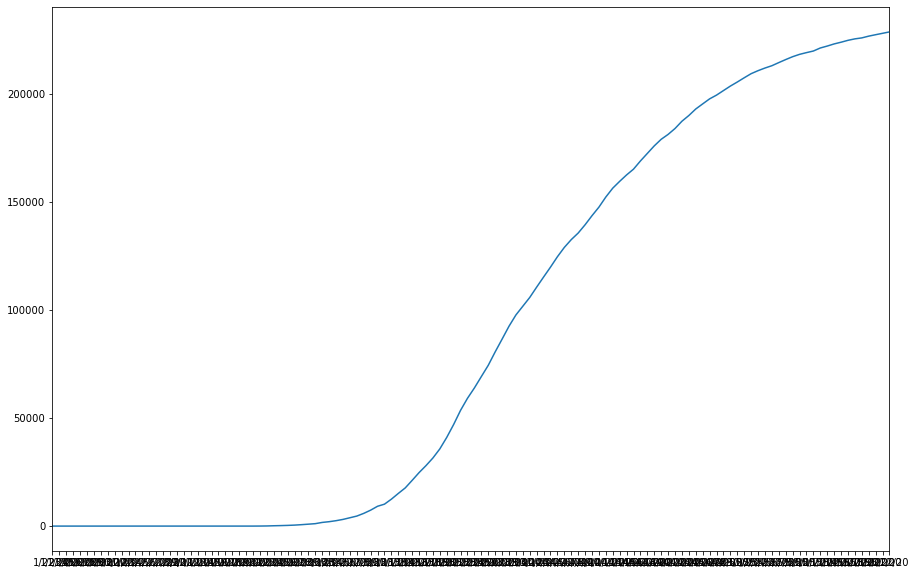

In [62]:
plt.figure(figsize=(15,10))
plt.autoscale(axis='x',tight=True)
plt.plot(df['Italy'])

In [63]:
test_data_size = 122

all_data = df['Italy'].values.astype(float)

train_data = all_data[:test_data_size]
test_data = all_data[test_data_size:]
print(len(train_data))
print(len(test_data))

122
0


In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [58]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[0.97575418]
 [0.98286524]
 [0.98868179]
 [0.99429716]
 [1.        ]]


In [17]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [18]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [97]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [98]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [99]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [100]:
epochs = 1


for country in training_countries:
    test_data_size = 122
    all_data = df[country].values.astype(float)
    train_data = all_data[:test_data_size]
    test_data = all_data[test_data_size:]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
    
    train_window = 11
    train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
    
    for i in range(epochs):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%5 == 1:
            print(f'country: {country} epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'country: {country} epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.0197756588
epoch:   0 loss: 0.0003864873
epoch:   0 loss: 0.0001113155
epoch:   0 loss: 0.0030409803
epoch:   0 loss: 0.0000241514
epoch:   0 loss: 0.0016108969
epoch:   0 loss: 0.0001534978
epoch:   0 loss: 0.0000032527
epoch:   0 loss: 0.0001535554


In [104]:
test_data = data.filter(testing_countries,axis=0).T.to_numpy()

scaler = MinMaxScaler(feature_range=(-1, 1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[-train_window:].tolist()

In [107]:
test_data_normalized[-train_window:]

tensor([0.7107, 0.7370, 0.7712, 0.8025, 0.8337, 0.8574, 0.8843, 0.9096, 0.9387,
        0.9703, 1.0000])

In [200]:
fut_pred = 200

test_inputs = test_data_normalized.tolist()
print(test_inputs)

[-1.0, -1.0, -0.9999987483024597, -0.9999987483024597, -0.9999949932098389, -0.9999949932098389, -0.9999949932098389, -0.9999949932098389, -0.9999949932098389, -0.9999924898147583, -0.999991238117218, -0.999991238117218, -0.9999874830245972, -0.9999874830245972, -0.9999874830245972, -0.9999874830245972, -0.9999874830245972, -0.9999874830245972, -0.9999874830245972, -0.9999874830245972, -0.9999862313270569, -0.9999862313270569, -0.9999849796295166, -0.9999849796295166, -0.9999849796295166, -0.9999849796295166, -0.9999849796295166, -0.9999849796295166, -0.9999849796295166, -0.9999849796295166, -0.9999825358390808, -0.9999825358390808, -0.9999825358390808, -0.9999375343322754, -0.9999375343322754, -0.9999300241470337, -0.9999287724494934, -0.9999262690544128, -0.9999163150787354, -0.9999088048934937, -0.9998788237571716, -0.9998538494110107, -0.9998151063919067, -0.9997276663780212, -0.9996677041053772, -0.9994977712631226, -0.9993528723716736, -0.9992666840553284, -0.9987994432449341, -0

In [201]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [202]:
test_inputs[fut_pred:]

[1.7167030572891235,
 1.7167659997940063,
 1.716822862625122,
 1.7168744802474976,
 1.7169214487075806,
 1.7169638872146606,
 1.717002272605896,
 1.7170370817184448,
 1.7170687913894653,
 1.7170976400375366,
 1.7171235084533691,
 1.7171472311019897,
 1.7171684503555298,
 1.7171880006790161,
 1.7172056436538696,
 1.7172216176986694,
 1.717236042022705,
 1.7172492742538452,
 1.7172611951828003,
 1.7172719240188599,
 1.717281699180603,
 1.7172906398773193,
 1.7172986268997192,
 1.7173060178756714,
 1.7173124551773071,
 1.7173185348510742,
 1.7173240184783936,
 1.7173289060592651,
 1.717333436012268,
 1.7173374891281128,
 1.7173410654067993,
 1.7173444032669067,
 1.717347502708435,
 1.7173501253128052,
 1.7173526287078857,
 1.7173548936843872,
 1.7173570394515991,
 1.7173588275909424,
 1.717360496520996,
 1.7173620462417603,
 1.7173634767532349,
 1.7173646688461304,
 1.7173658609390259,
 1.7173668146133423,
 1.7173678874969482,
 1.717368721961975,
 1.7173694372177124,
 1.7173701524734497,


In [203]:
len(test_inputs)

322

In [204]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs ).reshape(-1, 1))
print(actual_predictions.shape)

(322, 1)


In [224]:
x = np.arange(1, len(test_inputs)+1, 1)
start_date = datetime.strptime(data.columns[0], '%m/%d/%y')
labels = []
for i in x:
    t = start_date+timedelta(days=int(i-1))
    labels.append(str(t.month)+'/'+str(t.day)+'/'+str(t.year))
print(x)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

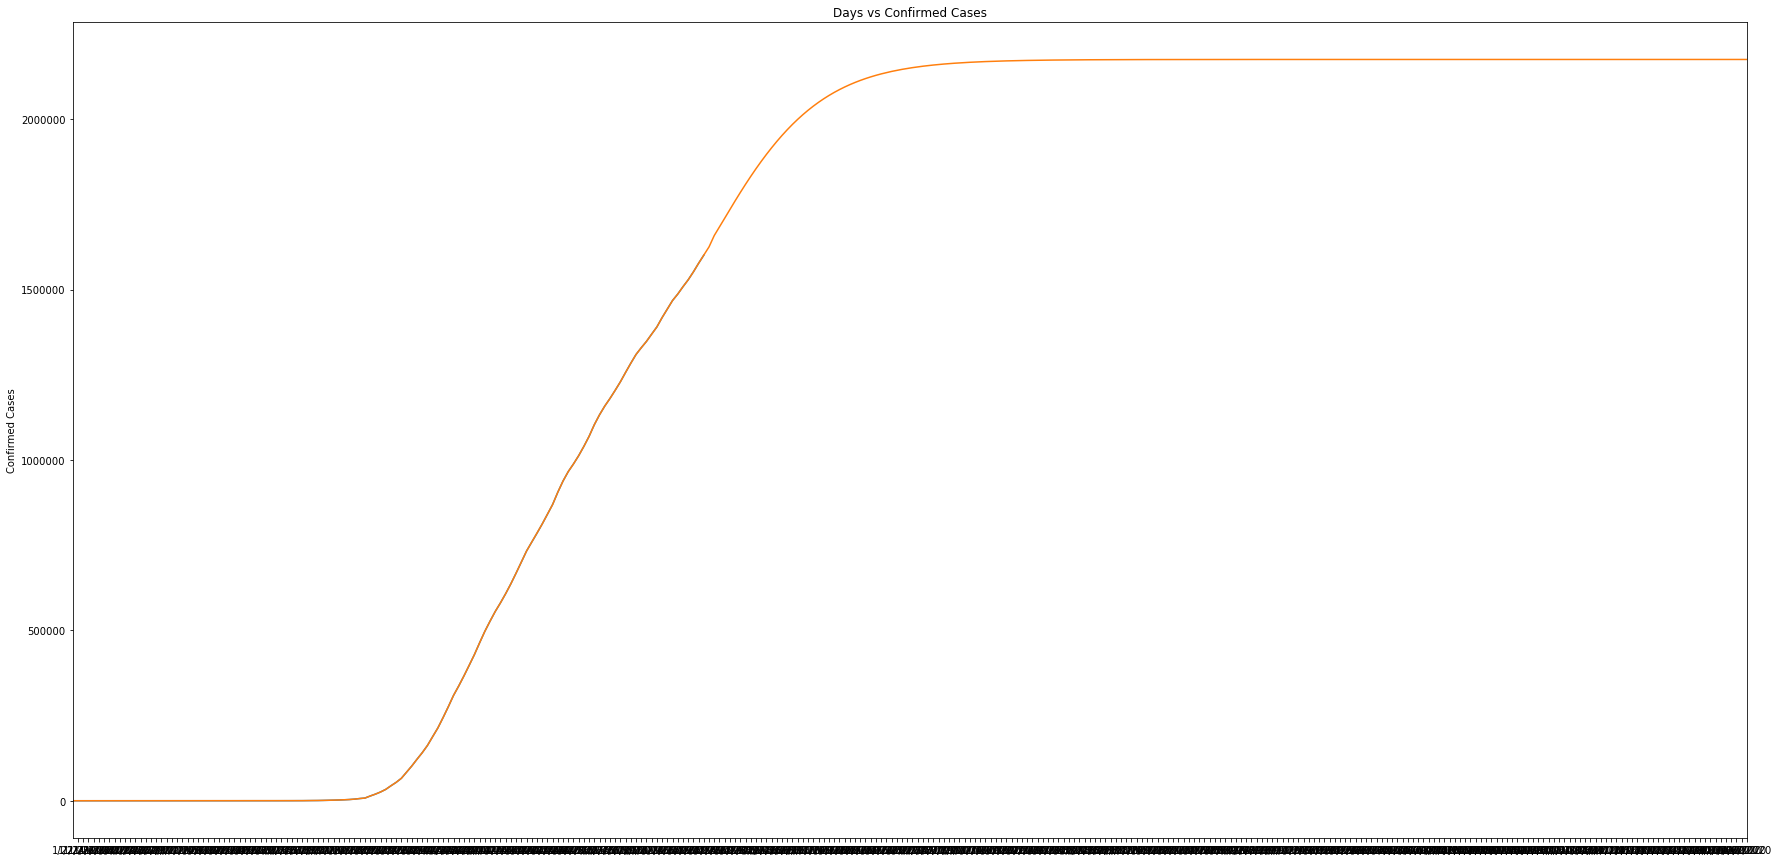

In [225]:
plt.figure(figsize=(30,15))
plt.title('Days vs Confirmed Cases')
plt.ylabel('Confirmed Cases')
# plt.grid(True)
# plt.xlabel(labels)
plt.xticks(x,labels)
plt.autoscale(axis='x', tight=True)
plt.plot(data.loc['US'])
plt.plot(actual_predictions)
plt.show()